In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch as torch
import torchvision as tv
from functools import partial
import os
import tempfile
from pathlib import Path
import fsspec
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from torchsummary import summary

c:\Users\joey5\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import torchvision.transforms as transforms
import pyarrow.fs
import ray.cloudpickle as pickle
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from tqdm import tqdm

In [3]:
class EmotionDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.split = False
        self.images = []
        self.labels = []
        self.load_data()

    def load_data(self):
        # Assuming a structure where each class has its own subdirectory
        for label, class_dir in enumerate(os.listdir(self.data_dir)):
            class_path = os.path.join(self.data_dir, class_dir)
            for count, img_name in enumerate(os.listdir(class_path)):
                # if count > 700:
                #     break
                img_path = os.path.join(class_path, img_name)
                self.images.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
class EmotionDatasetSplit(Dataset):
    def __init__(self, data_dir, transform=None, split=False, split_ratio=0.8):
        self.data_dir = data_dir
        self.transform = transform
        self.split = split
        self.split_ratio = split_ratio
        self.images = []
        self.labels = []
        self.train_indices = []
        self.val_indices = []
        self.load_data()
        
        if self.split:
            self.train_indices, self.val_indices = self._split_data()

    def load_data(self):
        # Assuming a structure where each class has its own subdirectory
        for label, class_dir in enumerate(os.listdir(self.data_dir)):
            class_path = os.path.join(self.data_dir, class_dir)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.images.append(img_path)
                        self.labels.append(label)

    def _split_data(self):
        indices = np.arange(len(self.images))
        train_indices, val_indices = train_test_split(indices, test_size=1-self.split_ratio, random_state=42)
        return train_indices, val_indices

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # if self.split:
        #     raise ValueError("Dataset is split into training and validation subsets. Use 'get_train_dataset()' or 'get_val_dataset()' to access the respective subset.")
        img_path = self.images[idx]
        image = Image.open(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_train_dataset(self):
        return Subset(self, self.train_indices)

    def get_val_dataset(self):
        return Subset(self, self.val_indices)

In [5]:
# split_test = EmotionDatasetSplit(data_dir='C:/Users/joey5/OneDrive/KU/Fourth Year/AppML/Final_Project', transform=transforms.Compose([transforms.ToTensor()]), 
#                                            split=True)

In [6]:
def load_custom_data(data_dir="./data", batch_size=1):
    transform = transforms.Compose([
        # transforms.RandomRotation(15),
        # transforms.RandomAffine(
        #     degrees=0,
        #     translate=(0.01, 0.12),
        #     shear=(0.01, 0.03),
        # ),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])

    train_dir = f"{data_dir}/train"
    test_dir = f"{data_dir}/test"
    
    trainset = EmotionDataset(data_dir=train_dir, transform=transform)
    testset = EmotionDataset(data_dir=test_dir, transform=transform)

    return trainset, testset

In [7]:
def load_custom_data_split(data_dir="./data", batch_size=1, split=False, split_ratio=0.8):
    transform = transforms.Compose([
        # transforms.RandomRotation(15),
        # transforms.RandomAffine(
        #     degrees=0,
        #     translate=(0.01, 0.12),
        #     shear=(0.01, 0.03),
        # ),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])

    train_dir = f"{data_dir}/train"
    test_dir = f"{data_dir}/test"
    
    split_test = EmotionDatasetSplit(data_dir=train_dir, transform=transform, split=split, split_ratio=split_ratio)
    trainset = split_test.get_train_dataset()
    valset = split_test.get_val_dataset()
    testset = EmotionDataset(data_dir=test_dir, transform=transform)

    return trainset,valset, testset

In [8]:
trainset_split, valset_split, testset_split = load_custom_data_split('C:/Users/joey5/OneDrive/KU/Fourth Year/AppML/Final_Project', batch_size=1, split=True, split_ratio=0.8)

In [9]:
# #print the shapes of the datasets

# print(f"Trainset: {len(trainset_split)}")
# print(f"Valset: {len(valset_split)}")
# print(f"Testset: {len(testset_split)}")

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [11]:
# Can be used for any Image Classification task

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        # loss = F.nll_loss(outputs, labels) # Convert for problem at hand
        acc = accuracy(outputs, labels)
        return {'loss': loss, 'acc': acc.detach()}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def get_metrics_epoch_end(self, outputs, validation=True):
        if validation:
            loss_ = 'val_loss'
            acc_ = 'val_acc'
        else:
            loss_ = 'loss'
            acc_ = 'acc'

        batch_losses = [x[f'{loss_}'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x[f'{acc_}'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {f'{loss_}': epoch_loss.detach().item(), f'{acc_}': epoch_acc.detach().item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        print(f"Epoch: {epoch+1}/{num_epochs} loss: {result['loss']:.4f}, acc: {result['acc']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}\n")

In [12]:
# Define custom kernels
horizontal_kernel = torch.tensor([[[-1, -1, -1],
                                   [ 0,  0,  0],
                                   [1, 1, 1]]], dtype=torch.float32)

vertical_kernel = torch.tensor([[[-1,  0, 1],
                                 [-1,  0, 1],
                                 [-1,  0, 1]]], dtype=torch.float32)

diagonal_kernel1 = torch.tensor([[[ 2, -1, -1],
                                  [-1,  2, -1],
                                  [-1, -1,  2]]], dtype=torch.float32)

diagonal_kernel2 = torch.tensor([[[-1, -1,  2],
                                  [-1,  2, -1],
                                  [ 2, -1, -1]]], dtype=torch.float32)

In [13]:
class EmotionRecognition(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),  # output: 128 x 24 x 24

            nn.Conv2d(128, 64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),  # output: 64 x 12 x 12

            nn.Conv2d(64, 32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),  # output: 32 x 6 x 6

            nn.Flatten(),
            nn.Linear(32 * 6 * 6, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 7)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        with torch.no_grad():
            # Initialize the first convolutional layer with custom kernels
            self.network[0].weight[0] = horizontal_kernel
            self.network[0].weight[1] = vertical_kernel
            self.network[0].weight[2] = diagonal_kernel1
            self.network[0].weight[3] = diagonal_kernel2
            # Initialize remaining filters randomly
            nn.init.xavier_normal_(self.network[0].weight[4:])
            nn.init.constant_(self.network[0].bias, 0)

    def forward(self, xb):
        return self.network(xb)

    def __repr__(self):
        return f"{self.network}"

    def __str__(self):
        summary(self.network, (1, 48, 48))

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return {'loss': loss}

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)         # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def get_metrics_epoch_end(self, outputs, validation=False):
        if validation:
            batch_losses = [x['val_loss'] for x in outputs]
            epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
            batch_accs = [x['val_acc'] for x in outputs]
            epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
            return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
        else:
            batch_losses = [x['loss'] for x in outputs]
            epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
            return {'train_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result, epochs):
        print(f"Epoch [{epoch+1}/{epochs}], train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")


In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.get_metrics_epoch_end(outputs=outputs, validation=True)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


In [15]:
def fit_model(model, epochs, lr, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD,model_name = "test_model"):
    
    BEST_VAL_SCORE = 0.0 # for keeping track of best model score
    history = []

    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay,momentum=0.9)

    for epoch in range(epochs):
        train_history = []

        # Training Phase 
        model.train()
        for batch in tqdm(train_loader, ascii=True, desc=f'Epoch: {epoch+1}/{epochs}'):
            info = model.training_step(batch)
            loss = info['loss']
            # contains batch loss and acc for training phase
            train_history.append(info)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

        train_result = model.get_metrics_epoch_end(train_history, validation=False)
        val_result = evaluate(model, val_loader)
        result = {**train_result, **val_result}
        model.epoch_end(epoch, result, epochs)

        # Save the best model
        if result['val_acc'] > BEST_VAL_SCORE:
            BEST_VAL_SCORE = result['val_acc']
            save_name = f"{model_name}_e{epoch+1}_sc-{round(result['val_acc'], 4)}.pth"
            torch.save(model.state_dict(), save_name)

        history.append(result)
    return history


@torch.no_grad()
def generate_prediction(model, data, extract=False):
    test_dl = DataLoader(data, batch_size=1, shuffle=False)

    model.eval()
    outputs = [model.validation_step(batch) for batch in test_dl]
    metrics = model.get_metrics_epoch_end(outputs=outputs, validation=True)
    
    if not extract:
        print(f"Test Scores:\n Loss: {round(metrics['val_loss'], 3)}, Accuracy: {round(metrics['val_acc'], 3)}")
    else:
        return metrics


def end_to_end(trainset, valset,testset, parameters, extract=False,tn = "test_model"):
    torch.cuda.empty_cache()

    BATCH_SIZE = parameters["batch_size"]
    epochs = parameters["epochs"]
    lr = parameters["lr"]
    weight_decay = parameters["weight_decay"]
    grad_clip = parameters["grad_clip"]
    opt_func = parameters["opt_func"]

    train_dl = DataLoader(trainset, BATCH_SIZE, shuffle=True)
    valid_dl = DataLoader(valset, BATCH_SIZE, shuffle=True)
    
    model = EmotionRecognition()

    history = fit_model(
                model, 
                epochs, 
                lr, 
                train_dl, 
                valid_dl,
                weight_decay, 
                grad_clip, 
                opt_func,
                model_name=tn
            )

    torch.cuda.empty_cache()

    print("Generating predictions on the Test set")
    pred = generate_prediction(model, testset, extract=extract)
    print("Test set prediction accuracy: ", pred['val_acc'])
    return history, pred

In [29]:
training_parameters = {
    "epochs": 10,
    "lr": 2e-3,
    "weight_decay": 0,
    "grad_clip": 0.5e-2,
    "opt_func": torch.optim.SGD,
    "batch_size": 64

}

In [30]:
trainset, testset = load_custom_data(data_dir="C:/Users/joey5/OneDrive/KU/Fourth Year/AppML/Final_Project", batch_size=1)


In [45]:
print('length of trainset:',len(trainset))

length of trainset: 28709


In [31]:
# train the model
history,pred = end_to_end(trainset_split,valset_split, testset_split, training_parameters, extract=True, tn="fm_3")

Epoch: 2/10:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch [1/10], train_loss: 1.6674, val_loss: 1.4702, val_acc: 0.4406


Epoch: 3/10:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch [2/10], train_loss: 1.3927, val_loss: 1.3441, val_acc: 0.4940


Epoch: 4/10:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch [3/10], train_loss: 1.2668, val_loss: 1.2843, val_acc: 0.5146


Epoch: 5/10:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch [4/10], train_loss: 1.1686, val_loss: 1.2592, val_acc: 0.5257


Epoch: 6/10:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch [5/10], train_loss: 1.0789, val_loss: 1.2414, val_acc: 0.5401


Epoch: 7/10:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch [6/10], train_loss: 0.9984, val_loss: 1.2496, val_acc: 0.5402


Epoch: 8/10:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch [7/10], train_loss: 0.9206, val_loss: 1.2768, val_acc: 0.5336


Epoch: 9/10:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch [8/10], train_loss: 0.8444, val_loss: 1.2932, val_acc: 0.5273


Epoch: 10/10:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch [9/10], train_loss: 0.7640, val_loss: 1.3395, val_acc: 0.5397


Epoch: 10/10: 100%|##########| 359/359 [05:09<00:00,  1.16it/s]


Epoch [10/10], train_loss: 0.6860, val_loss: 1.3858, val_acc: 0.5356
Generating predictions on the Test set
Test set prediction accuracy:  0.5346893072128296


In [32]:
training_parameters_weight_decay = {
    "epochs": 10,
    "lr": 2e-3,
    "weight_decay": 0.1,
    "grad_clip": 0.5e-2,
    "opt_func": torch.optim.SGD,
    "batch_size": 64

}

In [33]:
history_wd,pred_wd = end_to_end(trainset_split,valset_split, testset_split, training_parameters, extract=True, tn="fm_3.5_wd")

Epoch: 1/10:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch: 2/10:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch [1/10], train_loss: 1.6454, val_loss: 1.4392, val_acc: 0.4457


Epoch: 3/10:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch [2/10], train_loss: 1.3671, val_loss: 1.3607, val_acc: 0.4830


Epoch: 4/10:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch [3/10], train_loss: 1.2497, val_loss: 1.2950, val_acc: 0.5099


Epoch: 5/10:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch [4/10], train_loss: 1.1566, val_loss: 1.2436, val_acc: 0.5249


Epoch: 6/10:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch [5/10], train_loss: 1.0678, val_loss: 1.2629, val_acc: 0.5321


Epoch: 7/10:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch [6/10], train_loss: 0.9859, val_loss: 1.2850, val_acc: 0.5275


Epoch: 8/10:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch [7/10], train_loss: 0.9063, val_loss: 1.2756, val_acc: 0.5512


Epoch: 9/10:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch [8/10], train_loss: 0.8209, val_loss: 1.3071, val_acc: 0.5340


Epoch: 10/10:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch [9/10], train_loss: 0.7389, val_loss: 1.3931, val_acc: 0.5369


Epoch: 10/10: 100%|##########| 359/359 [05:09<00:00,  1.16it/s]


Epoch [10/10], train_loss: 0.6601, val_loss: 1.4428, val_acc: 0.5383
Generating predictions on the Test set
Test set prediction accuracy:  0.5286988019943237


In [38]:
# Load the model
model = EmotionRecognition()
model.load_state_dict(torch.load("fm_3_e6_sc-0.5402.pth"))

model_wd = EmotionRecognition()
model_wd.load_state_dict(torch.load("fm_3.5_wd_e7_sc-0.5512.pth"))
# 


<All keys matched successfully>

In [39]:

def plot_confusion_matrix(cm, class_names):
    figure, ax = plt.subplots(figsize=(5, 5))
    cm_norm = cm / np.sum(cm, axis=1, keepdims=True)
    ax.imshow(cm_norm, interpolation='nearest', cmap=plt.get_cmap('Blues'), vmin=0, vmax=1)
    accuracy_ = np.trace(cm) / float(np.sum(cm))
    ax.set_title(f'Accuracy: {100*accuracy_:.2f}%', fontsize=14, fontweight='bold')
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_names, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, f'{cm_norm[i, j]:.2f}', ha='center', va='center', color='k')

    figure.tight_layout()
    plt.xlabel('Predicted', fontweight='bold', fontsize=14)
    plt.ylabel('True', fontweight='bold', fontsize=14)
    plt.show()

def generate_confusion_matrix(model, data) -> None:
    '''Generate confusion matrix on the test set'''
    # load test dataset
    test_dl = DataLoader(data, batch_size=1, shuffle=False)

    # generate prediction using the validation step method defined in Base class
    with torch.no_grad():
        model.eval()
        all_preds = []
        all_labels = []
        for batch in test_dl:
            images, labels = batch
            preds = model(images)
            all_preds.append(preds)
            all_labels.append(labels)

        all_preds = torch.cat(all_preds, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        cm = confusion_matrix(all_labels.cpu().numpy(), torch.argmax(all_preds, dim=1).cpu().numpy())
        plot_confusion_matrix(cm, class_names=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])



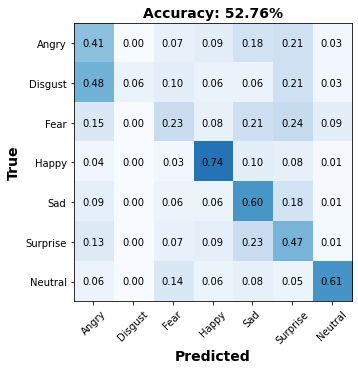

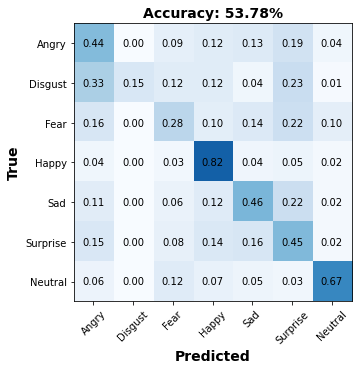

In [40]:
generate_confusion_matrix(model, testset)
generate_confusion_matrix(model_wd, testset)

In [41]:
# Generate the loss and accuracy plots
def plot_loss(history):
    losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    accs = [x['val_acc'] for x in history]
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses, '-x', label='train_loss')
    plt.plot(val_losses, '-o', label='val_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Loss vs. epochs')

    plt.subplot(1, 2, 2)
    plt.plot(accs, '-x', label='val_acc')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.title('Accuracy vs. epochs')
    plt.show()
    return losses, val_losses, accs

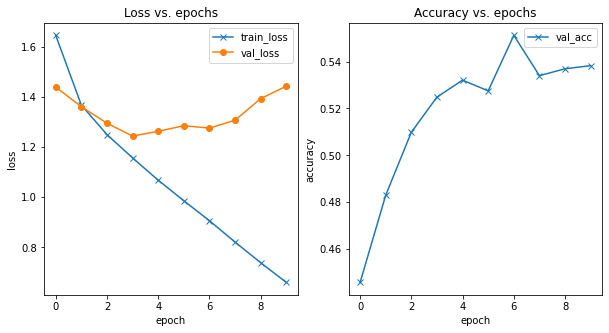

In [43]:
loss_wd,val_loss_wd, val_accs_wd =plot_loss(history_wd)

In [44]:
#Export the loss and accuracy values to separate csv files
df = pd.DataFrame(list(zip(loss_wd,val_loss_wd,val_accs_wd)), columns =['loss', 'val_loss','val_acc'])
df.to_csv('loss_wd.csv', index=False)



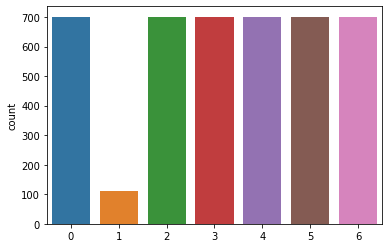

In [ ]:
# print the distribution of the classes in  the test set

# def class_distribution(data) -> None:
#     '''Print class distribution of the dataset'''
#     labels = [label for _, label in data]
#     sns.countplot(labels)
#     plt.show()

# class_distribution(testset)

In [ ]:
print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 48, 48]           1,280
              ReLU-2          [-1, 128, 48, 48]               0
            Conv2d-3          [-1, 128, 48, 48]         147,584
              ReLU-4          [-1, 128, 48, 48]               0
       BatchNorm2d-5          [-1, 128, 48, 48]             256
         MaxPool2d-6          [-1, 128, 24, 24]               0
            Conv2d-7           [-1, 64, 24, 24]          73,792
              ReLU-8           [-1, 64, 24, 24]               0
            Conv2d-9           [-1, 64, 24, 24]          36,928
             ReLU-10           [-1, 64, 24, 24]               0
      BatchNorm2d-11           [-1, 64, 24, 24]             128
        MaxPool2d-12           [-1, 64, 12, 12]               0
           Conv2d-13           [-1, 32, 12, 12]          18,464
             ReLU-14           [-1, 32,

TypeError: __str__ returned non-string (type NoneType)